In [1]:
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = MNIST('data/', train=True, transform=ToTensor())

C:\Users\preet\miniconda3\envs\myenv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
%ls

 Volume in drive C is OS
 Volume Serial Number is DE6D-9243

 Directory of C:\Users\preet\Desktop\Pytorch tut

04-09-2021  17:40    <DIR>          .
04-09-2021  17:40    <DIR>          ..
04-09-2021  09:01    <DIR>          .ipynb_checkpoints
04-09-2021  16:41                23 .jovianrc
01-09-2021  09:06    <DIR>          01-pytorch-basics-v-31
02-09-2021  12:32    <DIR>          02-linear-regression-v-30
03-09-2021  11:20    <DIR>          03-logistic-regression-v-32
04-09-2021  17:35    <DIR>          04-feedforward-nn-v-29
04-09-2021  08:59    <DIR>          05-cifar10-cnn-v-51
04-09-2021  10:03    <DIR>          data
04-09-2021  17:40           269,865 Untitled.ipynb
               2 File(s)        269,888 bytes
               9 Dir(s)  33,356,365,824 bytes free


In [4]:
image, label = dataset[0]

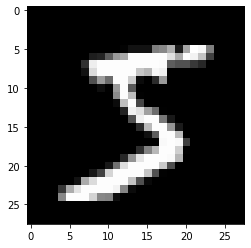

In [5]:
plt.imshow(image.permute(1,2,0), cmap='gray')

In [6]:
len(dataset)

60000

In [7]:
train_ds, val_ds = random_split(dataset, [50000,10000])

In [8]:
batch_size = 128
train_load = DataLoader(train_ds,batch_size, pin_memory=True, num_workers=4)
val_load = DataLoader(val_ds, batch_size, pin_memory=True, num_workers=4)

images.shape: torch.Size([128, 1, 28, 28])


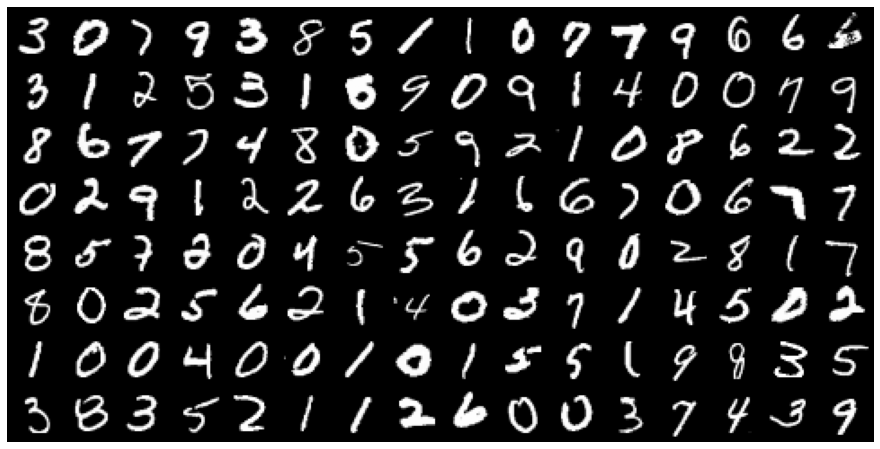

In [9]:
for images, _ in train_load:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [10]:
image = dataset[0]

In [11]:
inp_size = image[0].shape[1:][0] * image[0].shape[1:][0] 
inp_size

784

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [42]:
class mnistModel(nn.Module):
    def __init__(self, inp_size, hidden_layers, out_size):
        super(mnistModel, self).__init__()
        self.net = nn.Sequential()
        self.sig = nn.Sigmoid()
        self.net.add_module(module=nn.Linear(inp_size, hidden_layers[0]), name='Linear0')
        for i in range(1,len(hidden_layers)):
            self.net.add_module(module=nn.Linear(hidden_layers[i-1], hidden_layers[i]), name=f'Linear{i}')
            self.net.add_module(module=nn.ReLU(), name=f'ReLU{i}')
        self.net.add_module(module=nn.Linear(hidden_layers[-1], out_size), name='pred')
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.net(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        out = self.sig(out)
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        out = self.sig(out)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
    def evaluate(self, val_loader):
        outputs = [model.validation_step(batch) for batch in val_loader]
        return self.validation_epoch_end(outputs)
    
    def fit(self, epochs, lr, train_loader, val_loader, opt_func=torch.optim.SGD):
        optim = opt_func(self.net.parameters(), lr)
        for epoch in range(epochs):
            optim.zero_grad()
            for batch in train_load:
                loss = self.training_step(batch)
                loss.backward()
                optim.step()
                optim.zero_grad()
            result = self.evaluate(val_loader)
            self.epoch_end(epoch, result)
            
            

In [43]:
model = mnistModel(inp_size, [16], 10)

In [44]:
model

mnistModel(
  (net): Sequential(
    (Linear0): Linear(in_features=784, out_features=16, bias=True)
    (pred): Linear(in_features=16, out_features=10, bias=True)
  )
  (sig): Sigmoid()
)

In [45]:
for images, labels in train_load:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

Loss: 2.2956619262695312


In [46]:
model.fit(10, 0.01, train_load, val_load)

Epoch [0], val_loss: 2.2100, val_acc: 0.5573
Epoch [1], val_loss: 2.1129, val_acc: 0.6690
Epoch [2], val_loss: 2.0258, val_acc: 0.7019
Epoch [3], val_loss: 1.9550, val_acc: 0.7418
Epoch [4], val_loss: 1.8981, val_acc: 0.7734
Epoch [5], val_loss: 1.8539, val_acc: 0.7884
Epoch [6], val_loss: 1.8208, val_acc: 0.7910
Epoch [7], val_loss: 1.7953, val_acc: 0.7933
Epoch [8], val_loss: 1.7747, val_acc: 0.7957
Epoch [9], val_loss: 1.7576, val_acc: 0.7946
